# Data Analysis

#### Imports

In [1]:
%matplotlib inline

import pandas as pd
pd.options.display.max_rows = 999
import sqlite3
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#### Functions

In [2]:
def normalize(df, feature):
    '''Normalize data'''
    return (df[feature] - df[feature].mean()) / df[feature].std()

def removeOutliers(df, feature):
    '''Remove outliers (more than 3 std devs from mean)'''
    return df[np.abs(df[feature] - df[feature].mean()) <= (3 * df[feature].std())]

def convert_perc_int(df):
    ''''''
    df["occupancy"] = df["occupancy"].apply(lambda x: x * 100)
    df["occupancy"] = df["occupancy"].astype(int)
    return df

#### Database Connection

In [3]:
conn = sqlite3.connect("./sample.db")

#### Occupy Dataframe

In [4]:
df_occupy_1 = pd.read_sql(sql="SELECT room, date, time, associated_client_count, authenticated_client_count FROM occupy", con=conn)
df_occupy_2 = pd.read_sql(sql="SELECT room, date, time, module_code, occupancy FROM occupy", con=conn)

#### Only consider rows with the following conditions satisfied:

* **Condition 1**: time between 9:00 and 16:00
* **Condition 2:** This condition is because we want to take the average authenticated client count between these times. We are disregarding the other figures because we are not sure of the DHCP lease duration. For instance, a number of the devices could still be being considered from an individual who has already left the room but the lease is still considered.
    - time >= quarter past the hour
    - time <= quarter past the hour

In [5]:
df_occupy_1["condition1"] = df_occupy_1["time"].apply(lambda x: "true" if 16 >= int(x[0:2]) >= 9 else "false")
df_occupy_1 = df_occupy_1[df_occupy_1["condition1"] == "true"]

In [6]:
df_occupy_1["condition2"] = df_occupy_1["time"].apply(lambda x: "true" if 45 >= int(x[-2:]) >= 15 else "false")
df_occupy_1 = df_occupy_1[df_occupy_1["condition2"] == "true"]

In [7]:
del df_occupy_1["condition1"]
del df_occupy_1["condition2"]
df_occupy_1["time"] = df_occupy_1["time"].apply(lambda x: x[0:3] + "00")

In [8]:
df_occupy_merge = pd.merge(left = df_occupy_1, right = df_occupy_2, how="outer", on=["room", "date", "time"]) 

In [9]:
df_occupy = df_occupy_merge.groupby(["room", "date", "time", "module_code"], as_index=False).mean()
print(df_occupy.shape)

(172, 7)


#### Remove rows with NaN values 

In [10]:
df_occupy = df_occupy.dropna() 
print(df_occupy.shape)

(153, 7)


#### Module Dataframe

In [11]:
df_module = pd.read_sql(sql="SELECT * FROM module", con=conn)

#### Location Dataframe

In [12]:
df_location = pd.read_sql(sql="SELECT * FROM location", con=conn)

#### Close db connection

In [13]:
conn.close()

## Construct Analytics Base Table

#### Join tables

In [14]:
df_abt = pd.merge(left = df_occupy, right = df_module, how="outer", on=["module_code"]) 
df_abt = pd.merge(left = df_abt, right = df_location, how="outer", on=["room"]) 
print(df_abt.shape)

(154, 11)


#### Remove rows without registered students i.e. no class

In [15]:
df_abt = df_abt[df_abt["reg_students"] != 0]
print(df_abt.shape)

(130, 11)


#### Add occupancy ground truth number to ABT
#### Take min between occupancy gt and reg students to remove error in gt measurement

In [16]:
df_abt["occupancy_number"] = df_abt["occupancy"] * df_abt["capacity"]
df_abt["Difference"] = df_abt["occupancy_number"] - df_abt["reg_students"]
df_conor = df_abt[["room", "date", "time", "module_code", "reg_students", "occupancy_number", "Difference", "capacity"]].copy()
df_conor = df_conor[df_conor["Difference"] >= (df_conor["capacity"] * .125)]
df_conor[["room", "date", "time", "module_code", "reg_students", "occupancy_number", "Difference"]]

,room,date,time,module_code,reg_students,occupancy_number,Difference
4,B-002,2015-11-03,11:00,COMP30260,18,45.0,27.0
9,B-002,2015-11-03,12:00,COMP40370,27,45.0,18.0
15,B-002,2015-11-03,14:00,COMP30240,42,67.5,25.5
59,B-004,2015-11-13,15:00,COMP30220,38,80.0,42.0
97,B-004,2015-11-12,10:00,MATH10130,56,80.0,24.0
107,B-004,2015-11-09,15:00,COMP41110,19,80.0,61.0
116,B-003,2015-11-03,11:00,COMP10280,56,67.5,11.5


In [17]:
df_abt["min_occ_reg"] = df_abt.loc[:, ['occupancy_number', 'reg_students']].min(axis=1)
print(df_abt.shape)

(130, 14)


#### Drop NaN rows

In [18]:
df_abt = df_abt.dropna() 
print(df_abt.shape)

(128, 14)


# Models

### Model 1: Simple Linear (Y: min_occ_reg, X: authenticated_client_count)

In [19]:
df_reg_1= df_abt[["min_occ_reg", "authenticated_client_count"]].copy()
print(df_reg_1.shape)

(128, 2)


#### Feature Analysis

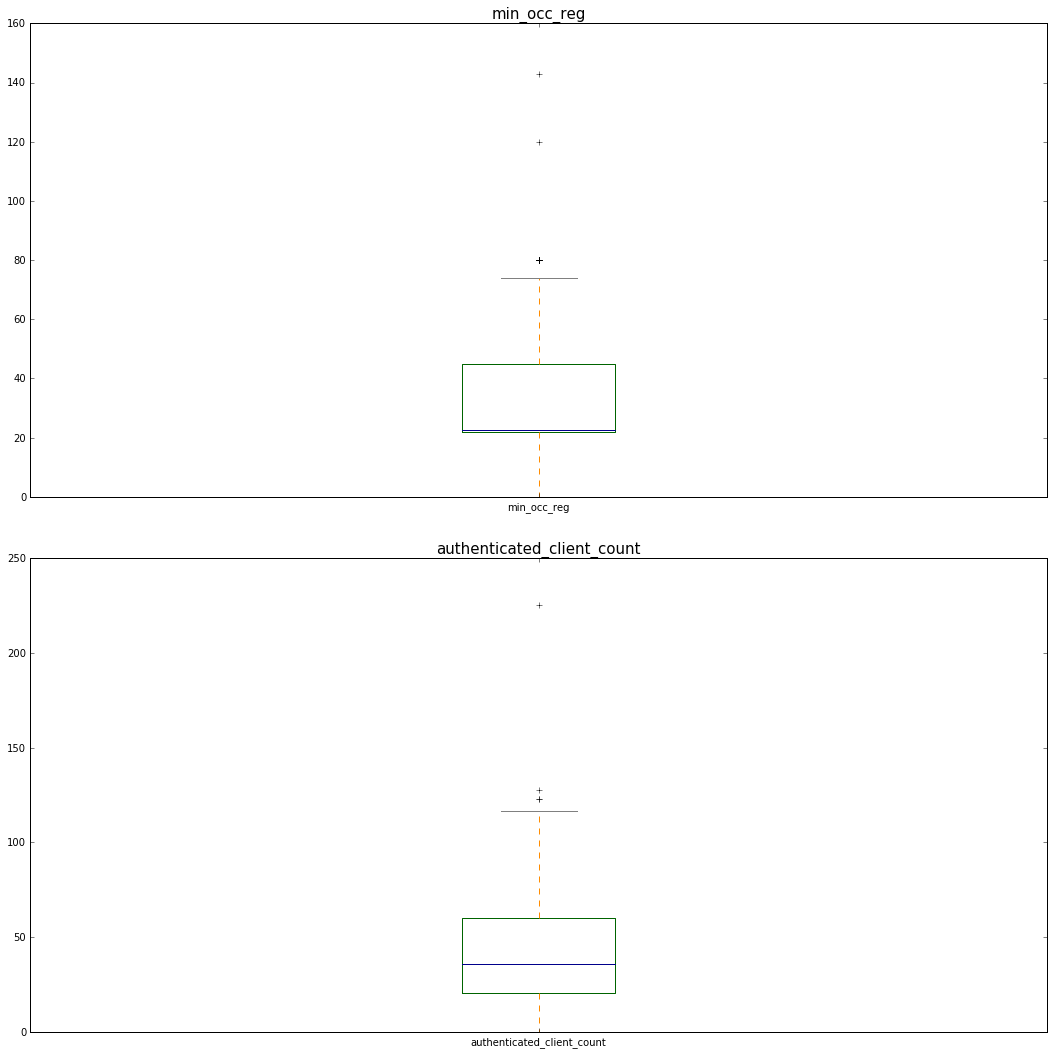

In [20]:
colour = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray') 
plt.figure() 
plt.subplot(211).set_title("min_occ_reg", fontsize=15)
df_reg_1["min_occ_reg"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.subplot(212).set_title("authenticated_client_count", fontsize=15)
df_reg_1["authenticated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) 

#### Normalize Features and remove outliers

In [21]:
df_reg_1["min_occ_reg_NORM"] = normalize(df_reg_1, "min_occ_reg")
df_reg_1["auth_client_count_NORM"] = normalize(df_reg_1, "authenticated_client_count")
print(df_reg_1.shape)
df_reg_1 = removeOutliers(df_reg_1, "min_occ_reg_NORM")
df_reg_1 = removeOutliers(df_reg_1, "auth_client_count_NORM")
df_reg_1 = df_reg_1[["min_occ_reg", "authenticated_client_count"]]
print(df_reg_1.shape)

(128, 4)
(125, 2)


In [22]:
print(df_reg_1.dtypes)
corrMatrix = df_reg_1.corr()
corrMatrix

min_occ_reg                   float64
authenticated_client_count    float64
dtype: object


,min_occ_reg,authenticated_client_count
min_occ_reg,1.000000,0.693793
authenticated_client_count,0.693793,1.000000


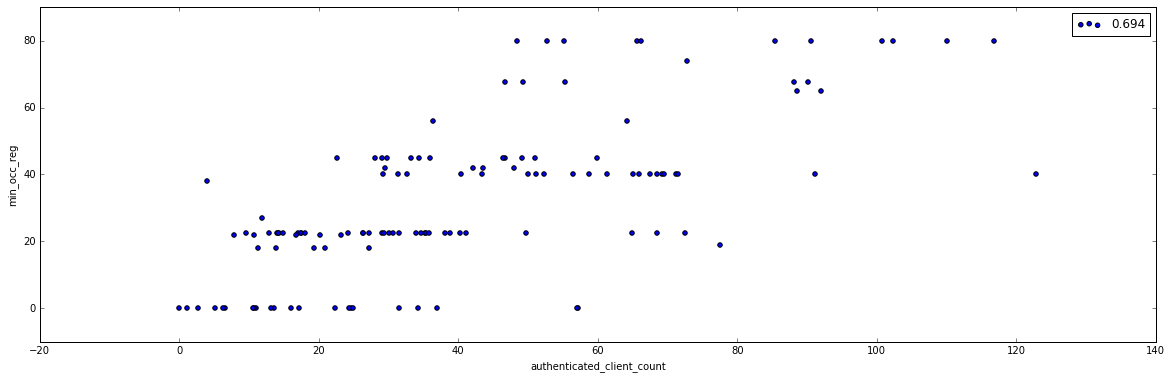

In [23]:
plt.figure() 
df_reg_1.plot(kind="scatter", x="authenticated_client_count", y="min_occ_reg", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))

#### Statsmodels

In [24]:
# lm_sm = sm.ols(formula="min_occ_reg ~ authenticated_client_count", data=df_reg_1).fit()
# print(lm_sm.summary())

#### Scikit Learn

Coefficients: 
 [ 0.60086851]
Intercept: 
 7.88177302973
Residual sum of squares: 280.40
Square Root of Residual sum of squares: 16.75
Variance score: 0.48


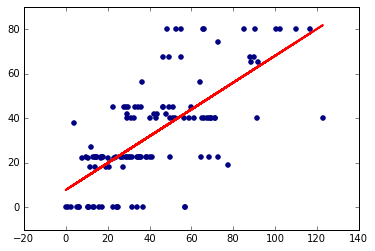

In [25]:
X = df_reg_1["authenticated_client_count"].reshape(len(df_reg_1["authenticated_client_count"]), 1)
y = df_reg_1["min_occ_reg"]

lm_scikit_1 = LinearRegression()

# Fit the model 
lm_scikit_1.fit(X, y)

# Coefficients
print("Coefficients: \n", lm_scikit_1.coef_)
# The intercept
print('Intercept: \n', lm_scikit_1.intercept_)
# The mean square error: MSE is more popular than MAE because MSE "punishes" larger errors. 
# But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y, lm_scikit_1.predict(X)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y, lm_scikit_1.predict(X))))
# Explained variance score: coefficient of determination (R^2)
print("Variance score: %.2f" % lm_scikit_1.score(X, y))

# Plot outputs
plt.scatter(X, y,  color='navy')
plt.plot(X, lm_scikit_1.predict(X), color='red',linewidth=2)
plt.figure(figsize=(20,20))
plt.show()

#### Train & Testing

**Cross Validation**

In [26]:
R2_scores_1 = cross_val_score(lm_scikit_1.fit(X, y), X.astype(int), y.astype(int), cv=5, scoring="r2")
print(R2_scores_1)

[ 0.24550165 -0.08107307  0.28460772  0.4503266   0.32127097]


**Train and test** 

Coefficients:  [ 0.52113375]
Intercept:  9.63951291616
Residual sum of squares: 274.18
Square Root of Residual sum of squares: 16.56
Variance score: 0.57


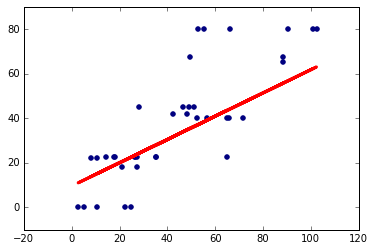

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lm_scikit_1_t = LinearRegression()

# Train the model using the training sets
lm_scikit_1_t.fit(X_train, y_train)

# The coefficients
print('Coefficients: ', lm_scikit_1_t.coef_)
# The intercept
print('Intercept: ', lm_scikit_1_t.intercept_)
# The mean square error
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y_test, lm_scikit_1_t.predict(X_test)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y_test, lm_scikit_1_t.predict(X_test))))
# Explained variance score: coefficient of determination (R^2)
print('Variance score: %.2f' % lm_scikit_1_t.score(X_test, y_test))

# Plot outputs
plt.scatter(X_test, y_test,  color='navy')
plt.plot(X_test, lm_scikit_1_t.predict(X_test), color='red',linewidth=3)
plt.figure(figsize=(20,20))
plt.show()

### Model 2: Simple Linear (Y: min_occ_reg, X: asso_client_count)

In [28]:
df_reg_2= df_abt[["min_occ_reg", "associated_client_count"]].copy()
print(df_reg_2.shape)

(128, 2)


#### Feature Analysis

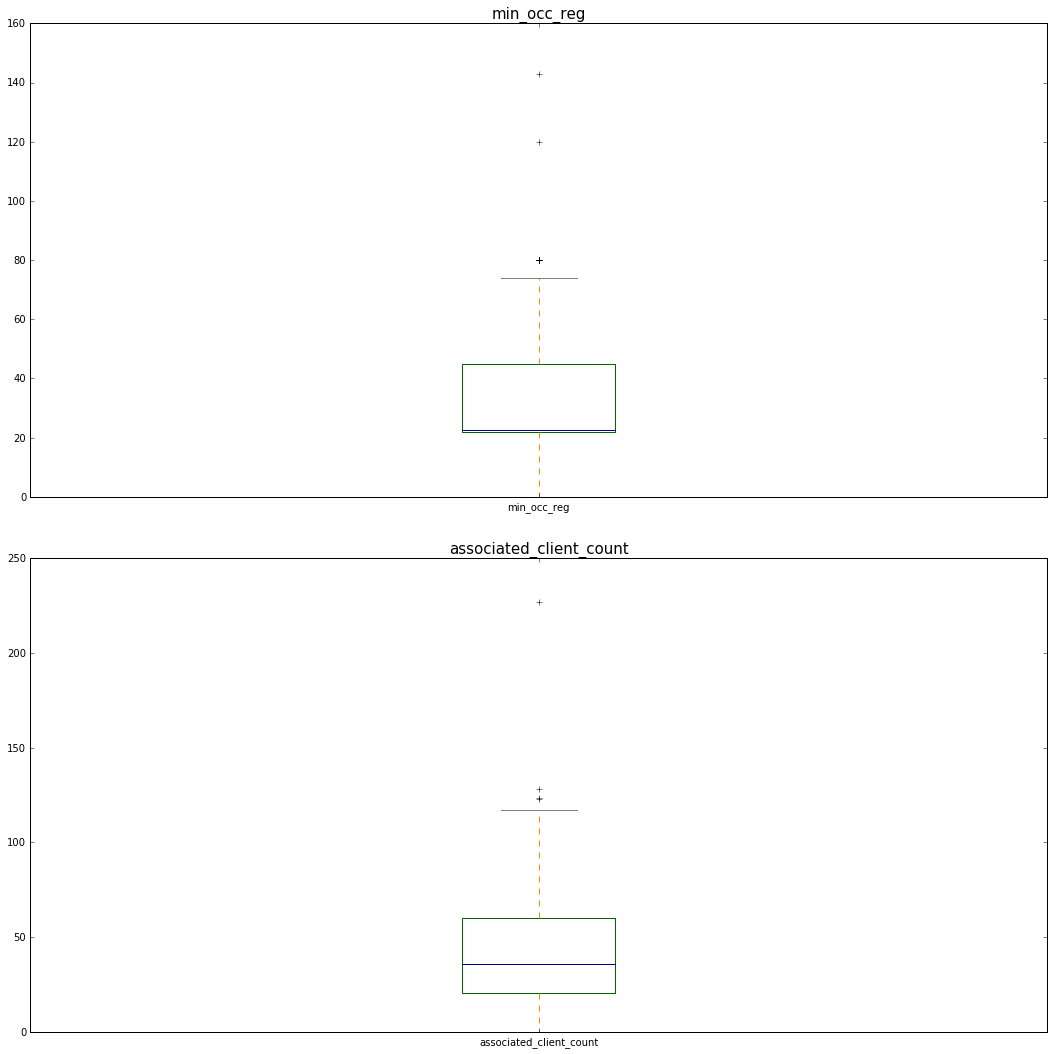

In [29]:
plt.figure() 
plt.subplot(211).set_title("min_occ_reg", fontsize=15)
df_reg_2["min_occ_reg"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.subplot(212).set_title("associated_client_count", fontsize=15)
df_reg_2["associated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) #set padding

#### Normalize Features and remove outliers

In [30]:
df_reg_2["min_occ_reg_NORM"] = normalize(df_reg_2, "min_occ_reg")
df_reg_2["asso_client_count_NORM"] = normalize(df_reg_2, "associated_client_count")
print(df_reg_2.shape)
df_reg_2 = removeOutliers(df_reg_2, "min_occ_reg_NORM")
df_reg_2 = removeOutliers(df_reg_2, "asso_client_count_NORM")
df_reg_2 = df_reg_2[["min_occ_reg", "associated_client_count"]]
print(df_reg_2.shape)

(128, 4)
(125, 2)


In [31]:
print(df_reg_2.dtypes)
corrMatrix = df_reg_2.corr()
corrMatrix

min_occ_reg                float64
associated_client_count    float64
dtype: object


,min_occ_reg,associated_client_count
min_occ_reg,1.000000,0.693639
associated_client_count,0.693639,1.000000


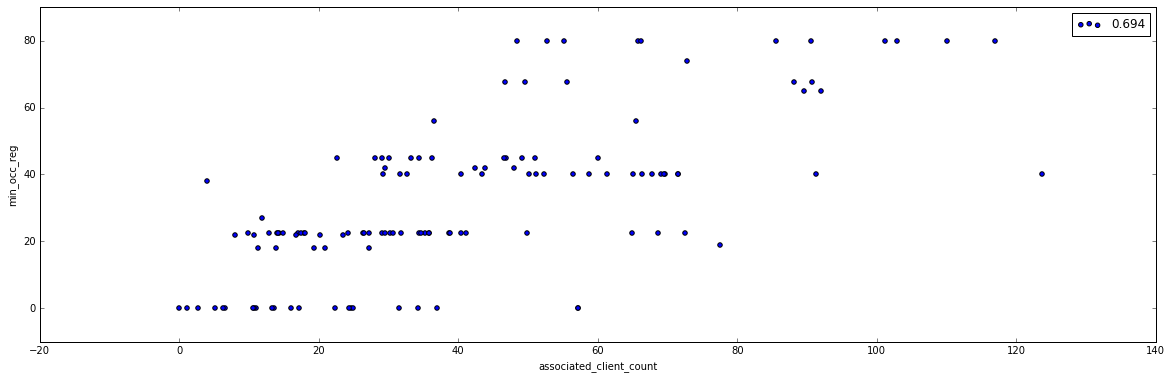

In [32]:
plt.figure() 
df_reg_2.plot(kind="scatter", x="associated_client_count", y="min_occ_reg", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))

In [33]:
# lm_sm_2 = sm.ols(formula="min_occ_reg ~ associated_client_count - 1", data=df_reg_2).fit()
# print(lm_sm_2.summary())

Coefficients: 
 [ 0.59885264]
Intercept: 
 7.89820771409
Residual sum of squares: 280.51
Square Root of Residual sum of squares: 16.75
Variance score: 0.48


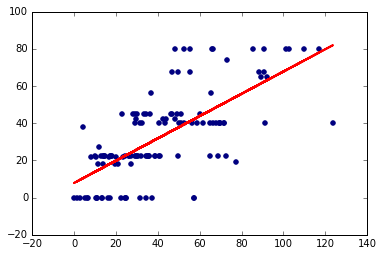

In [34]:
X = df_reg_2["associated_client_count"].reshape(len(df_reg_2["associated_client_count"]), 1)
y = df_reg_2["min_occ_reg"]

lm_scikit_2 = LinearRegression()

# Fit the model 
lm_scikit_2.fit(X, y)

# Coefficients
print("Coefficients: \n", lm_scikit_2.coef_)
# The intercept
print('Intercept: \n', lm_scikit_2.intercept_)
# The mean square error: MSE is more popular than MAE because MSE "punishes" larger errors. 
# But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y, lm_scikit_2.predict(X)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y, lm_scikit_2.predict(X))))
# Explained variance score: coefficient of determination (R^2)
print("Variance score: %.2f" % lm_scikit_2.score(X, y))

# Plot outputs
plt.scatter(X, y,  color='navy')
plt.plot(X, lm_scikit_2.predict(X), color='red',linewidth=2)
plt.figure(figsize=(20,20))
plt.show()

#### Train & Testing

**Cross Validation**

In [35]:
R2_scores_2 = cross_val_score(lm_scikit_2.fit(X, y), X.astype(int), y.astype(int), cv=5)
print(R2_scores_2)

[ 0.24260432 -0.07764585  0.28032236  0.45079952  0.32430428]


**Train and test** 

Coefficients: 
 [ 0.61854775]
Intercept: 
 7.95891817203
Residual sum of squares: 263.13
Square Root of Residual sum of squares: 16.22
Variance score: 0.46


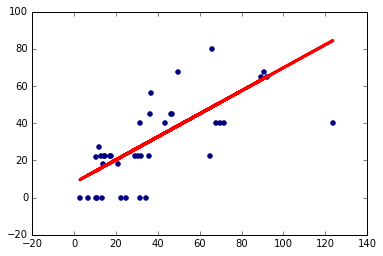

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lm_scikit_2_t = LinearRegression()

# Train the model using the training sets
lm_scikit_2_t.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', lm_scikit_2_t.coef_)
# The intercept
print('Intercept: \n', lm_scikit_2_t.intercept_)
# The mean square error
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y_test, lm_scikit_2_t.predict(X_test)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y_test, lm_scikit_2_t.predict(X_test))))
# Explained variance score: coefficient of determination (R^2)
print('Variance score: %.2f' % lm_scikit_2_t.score(X_test, y_test))

# Plot outputs
plt.scatter(X_test, y_test,  color='navy')
plt.plot(X_test, lm_scikit_2_t.predict(X_test), color='red',linewidth=3)
plt.figure(figsize=(20,20))
plt.show()

### Categoriztion Models

In [37]:
df = df_abt[["occupancy", "authenticated_client_count", "capacity"]].copy()
df = convert_perc_int(df)

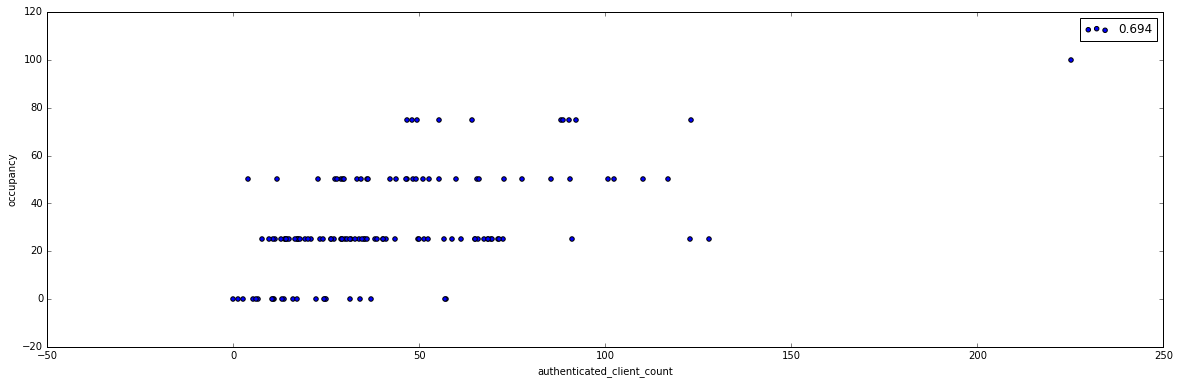

In [38]:
plt.figure() 
df.plot(kind="scatter", x="authenticated_client_count", y="occupancy", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))

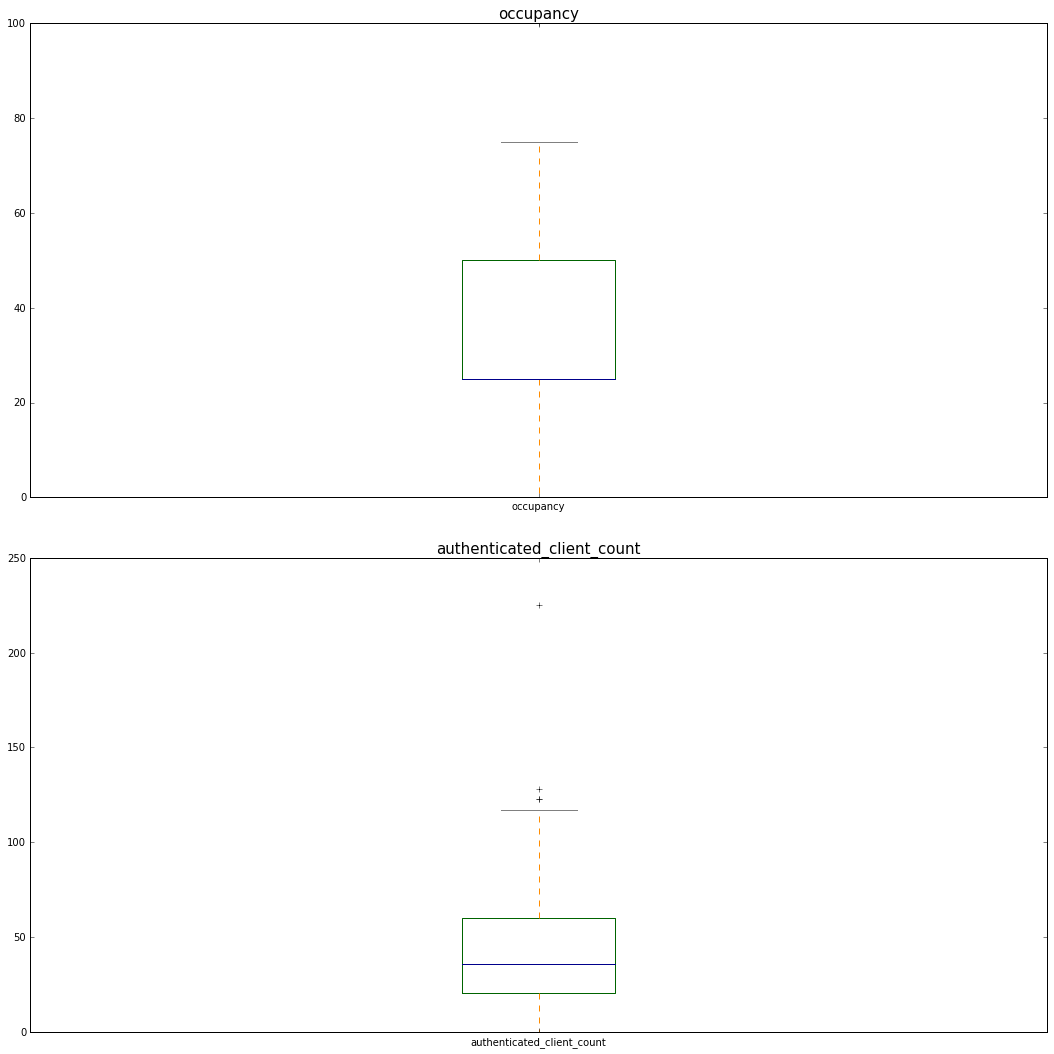

In [39]:
plt.figure() 
plt.subplot(211).set_title("occupancy", fontsize=15)
df["occupancy"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.subplot(212).set_title("authenticated_client_count", fontsize=15)
df["authenticated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) 

In [40]:
# df["occupancy_NORM"] = normalize(df, "occupancy")
# df["authenticated_client_count_NORM"] = normalize(df, "authenticated_client_count")
# print(df.shape)
# df = removeOutliers(df, "occupancy_NORM")
# df = removeOutliers(df, "authenticated_client_count_NORM")
# df = df[["occupancy", "authenticated_client_count"]]
# print(df.shape)

### Multinomial Logistic Regression http://machinelearningmastery.com/get-your-hands-dirty-with-scikit-learn-now/

log-odds of a categorical response being "true" (1) is modeled as a linear combination of the features.
Logistic regression outputs the probabilities of a specific class
Those probabilities can be converted into class predictions

In [41]:
df_log_1 = df.copy()
occ = df_log_1["occupancy"].copy().apply(lambda x: (x / 100) * df_log_1["capacity"].values[0])
EXP = []
for a, o in zip(df_log_1["authenticated_client_count"], occ):
    EXP.append([a, o])

X = np.array(EXP)
# X = df_log_1["authenticated_client_count"].div(df_log_1["capacity"]).reshape(len(df_log_1["authenticated_client_count"]), 1)
# X = df_log_1["authenticated_client_count"].reshape(len(df_log_1["authenticated_client_count"]), 1)
y = df_log_1["occupancy"]
lr = LogisticRegression()
lr.fit(X, y)
pred_lr = lr.predict(X)
print(metrics.classification_report(y, pred_lr))
print(metrics.confusion_matrix(y, pred_lr))
print(metrics.accuracy_score(y, pred_lr) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
         25       0.89      1.00      0.94        63
         50       0.69      0.75      0.72        32
         75       0.00      0.00      0.00        10
        100       0.00      0.00      0.00         1

avg / total       0.78      0.85      0.81       128

[[22  0  0  0  0]
 [ 0 63  0  0  0]
 [ 0  8 24  0  0]
 [ 0  0 10  0  0]
 [ 0  0  1  0  0]]
0.8515625


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Testing

In [42]:
clf = LogisticRegression()
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.84 (+/- 0.11)


//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
clf = LogisticRegression().fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.826923076923


In [44]:
df_log_1["predicted"] = pd.Series(pred_lr, index=df_log_1.index)

0      50
1      50
2       0
3      25
4      50
5      25
6      25
7      25
8      25
9      50
10     25
11     25
12     25
13     25
14     25
15     50
16     25
17     25
18     25
19     50
20     50
21     50
22     25
23     25
24     25
25     25
26     25
27     25
28      0
29      0
30     25
31     25
32     25
33      0
34     25
35     25
36     25
37     25
38     25
39     50
40      0
41     25
42     25
43     25
44     25
45      0
46      0
47      0
48      0
49     25
52     50
53      0
54     25
55     25
56     25
57      0
58      0
59     50
60     25
61     25
62     25
63     25
64     25
65     25
66     25
67     50
68     50
69     25
70     25
71     25
72     25
73     50
74     25
75     25
76     25
77     50
78     50
79     25
80      0
83     25
84      0
85     25
86      0
87     25
88     25
89      0
90     25
91     25
92      0
93     25
94      0
95      0
96     25
97     50
98     25
99     25
100    25
101    25
102    25
103    50


In [45]:
####### How to use model to return occupancy prediction #######
# lr.predict_proba(X)
# groups = [0, 25, 50, 75, 100]
# lr.predict_proba(X).argmax(axis=1)

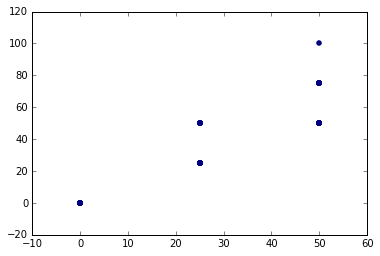

In [46]:
plt.scatter(df_log_1["predicted"], df_log_1["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

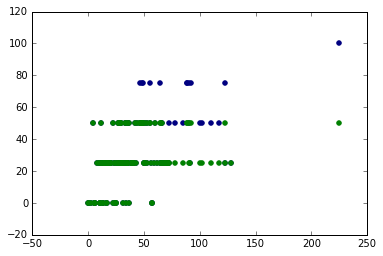

In [47]:
plt.scatter(df_log_1["authenticated_client_count"], df_log_1["occupancy"],  color='navy')
plt.scatter(df_log_1["authenticated_client_count"], df_log_1["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()

### Gaussian Naive Bayes 

In [48]:
df_gnb = df.copy()

occ = df_gnb["occupancy"].copy().apply(lambda x: (x / 100) * df_gnb["capacity"].values[0])
EXP = []
for a, o in zip(df_gnb["authenticated_client_count"], occ):
    EXP.append([a, o])
X = np.array(EXP)
# X = df_gnb["authenticated_client_count"].div(df_gnb["capacity"]).reshape(len(df_gnb["authenticated_client_count"]), 1)
# X = df_gnb["authenticated_client_count"].reshape(len(df_gnb["authenticated_client_count"]), 1)
y = df_gnb["occupancy"]
# fit a Naive Bayes model to the data
gnb = GaussianNB()
gnb.fit(X, y)
pred_gnb = gnb.predict(X)
print(metrics.classification_report(y, pred_gnb))
print(metrics.confusion_matrix(y, pred_gnb))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
         25       1.00      1.00      1.00        63
         50       1.00      1.00      1.00        32
         75       1.00      1.00      1.00        10
        100       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00       128

[[22  0  0  0  0]
 [ 0 63  0  0  0]
 [ 0  0 32  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0  1]]


#### Testing

In [49]:
clf = GaussianNB()
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.99 (+/- 0.03)


//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
clf = GaussianNB().fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

1.0


In [51]:
df_gnb["predicted"] = pd.Series(pred_gnb, index=df_gnb.index)

0       50
1       50
2        0
3       25
4       50
5       25
6       25
7       25
8       25
9       50
10      25
11      25
12      25
13      25
14      25
15      75
16      25
17      25
18      25
19      50
20      50
21      50
22      25
23      25
24      25
25      25
26      25
27      25
28       0
29       0
30      25
31      25
32      25
33       0
34      25
35      25
36      25
37      25
38      25
39      50
40       0
41      25
42      25
43      25
44      25
45       0
46       0
47       0
48       0
49      25
52      50
53       0
54      25
55      25
56      25
57       0
58       0
59      50
60      25
61      25
62      25
63      50
64      25
65      25
66      25
67      75
68     100
69      25
70      50
71      50
72      25
73      50
74      25
75      25
76      25
77      50
78      50
79      25
80       0
83      25
84       0
85      25
86       0
87      25
88      25
89       0
90      50
91      25
92       0
93      25
94       0

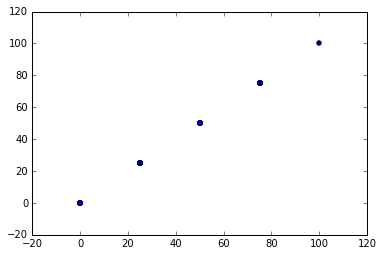

In [52]:
plt.scatter(df_gnb["predicted"], df_gnb["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

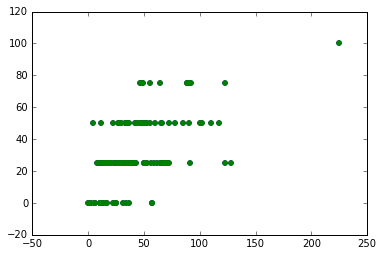

In [53]:
plt.scatter(df_gnb["authenticated_client_count"], df_gnb["occupancy"],  color='navy')
plt.scatter(df_gnb["authenticated_client_count"], df_gnb["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()

### k-Nearest Neighbor

In [54]:
df_nn = df.copy()
occ = df_nn["occupancy"].copy().apply(lambda x: (x / 100) * df_nn["capacity"].values[0])
EXP = []
for a, o in zip(df_nn["authenticated_client_count"], occ):
    EXP.append([a, o])
X = np.array(EXP)

# X = df_nn["authenticated_client_count"].div(df_nn["capacity"]).reshape(len(df_nn["authenticated_client_count"]), 1)
# X = df_nn["authenticated_client_count"].reshape(len(df_nn["authenticated_client_count"]), 1)
y = df_nn["occupancy"] 
nn = KNeighborsClassifier() # default n_neighbors=5
nn.fit(X, y)
pred_nn = nn.predict(X)
print(metrics.classification_report(y, pred_nn))
print(metrics.confusion_matrix(y, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
         25       0.98      0.97      0.98        63
         50       0.91      1.00      0.96        32
         75       1.00      0.90      0.95        10
        100       0.00      0.00      0.00         1

avg / total       0.96      0.97      0.97       128

[[22  0  0  0  0]
 [ 0 61  2  0  0]
 [ 0  0 32  0  0]
 [ 0  0  1  9  0]
 [ 0  1  0  0  0]]


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Testing

In [55]:
clf = KNeighborsClassifier()
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.94 (+/- 0.10)


//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
scores=[]
for n in range(2,15):
    clf = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    scores.append(round(clf.score(X_test, y_test),2))
neighbours = scores.index(max(scores)) + 1
print(scores)

[1.0, 0.95999999999999996, 0.95999999999999996, 0.97999999999999998, 0.90000000000000002, 0.93999999999999995, 0.90000000000000002, 0.90000000000000002, 0.87, 0.87, 0.81000000000000005, 0.81000000000000005, 0.81000000000000005]


In [57]:
df_nn["predicted"] = pd.Series(pred_nn, index=df_nn.index)

0      50
1      50
2       0
3      25
4      50
5      25
6      25
7      25
8      25
9      50
10     25
11     25
12     25
13     25
14     25
15     75
16     25
17     25
18     25
19     50
20     50
21     50
22     25
23     25
24     25
25     25
26     25
27     25
28      0
29      0
30     25
31     25
32     25
33      0
34     25
35     25
36     25
37     25
38     25
39     50
40      0
41     25
42     25
43     25
44     25
45      0
46      0
47      0
48      0
49     25
52     50
53      0
54     25
55     25
56     25
57      0
58      0
59     50
60     25
61     25
62     25
63     50
64     25
65     25
66     25
67     50
68     25
69     25
70     50
71     50
72     50
73     50
74     25
75     25
76     25
77     50
78     50
79     25
80      0
83     25
84      0
85     25
86      0
87     25
88     25
89      0
90     50
91     25
92      0
93     25
94      0
95      0
96     25
97     50
98     50
99     50
100    50
101    50
102    25
103    50


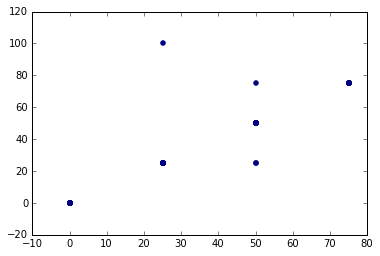

In [58]:
plt.scatter(df_nn["predicted"], df_nn["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

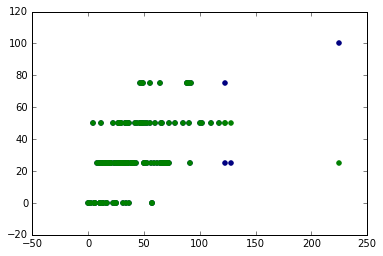

In [59]:
plt.scatter(df_nn["authenticated_client_count"], df_nn["occupancy"],  color='navy')
plt.scatter(df_nn["authenticated_client_count"], df_nn["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()

### Support Vector Machines

In [60]:
df_svm = df.copy()

occ = df_svm["occupancy"].copy().apply(lambda x: (x / 100) * df_svm["capacity"].values[0])
EXP = []
for a, o in zip(df_svm["authenticated_client_count"], occ):
    EXP.append([a, o])
X = np.array(EXP)

# X = df_svm["authenticated_client_count"].div(df_svm["capacity"]).reshape(len(df_svm["authenticated_client_count"]), 1)
# X = df_svm["authenticated_client_count"].reshape(len(df_svm["authenticated_client_count"]), 1)
y = df_svm["occupancy"] 
svc = SVC()
svc.fit(X, y)
pred_svm = svc.predict(X)
print(metrics.classification_report(y, pred_svm))
print(metrics.confusion_matrix(y, pred_svm))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
         25       1.00      1.00      1.00        63
         50       1.00      1.00      1.00        32
         75       1.00      1.00      1.00        10
        100       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00       128

[[22  0  0  0  0]
 [ 0 63  0  0  0]
 [ 0  0 32  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0  1]]


#### Testing

In [61]:
clf = SVC()
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.10)


//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
clf = SVC().fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.692307692308


In [63]:
df_svm["predicted"] = pd.Series(pred_svm, index=df_svm.index)

0       50
1       50
2        0
3       25
4       50
5       25
6       25
7       25
8       25
9       50
10      25
11      25
12      25
13      25
14      25
15      75
16      25
17      25
18      25
19      50
20      50
21      50
22      25
23      25
24      25
25      25
26      25
27      25
28       0
29       0
30      25
31      25
32      25
33       0
34      25
35      25
36      25
37      25
38      25
39      50
40       0
41      25
42      25
43      25
44      25
45       0
46       0
47       0
48       0
49      25
52      50
53       0
54      25
55      25
56      25
57       0
58       0
59      50
60      25
61      25
62      25
63      50
64      25
65      25
66      25
67      75
68     100
69      25
70      50
71      50
72      25
73      50
74      25
75      25
76      25
77      50
78      50
79      25
80       0
83      25
84       0
85      25
86       0
87      25
88      25
89       0
90      50
91      25
92       0
93      25
94       0

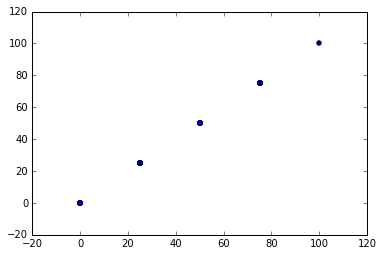

In [64]:
plt.scatter(df_svm["predicted"], df_svm["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

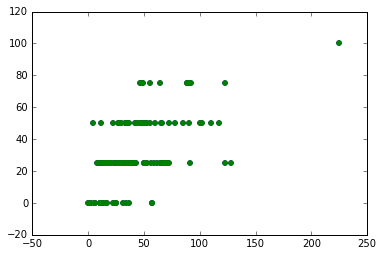

In [65]:
plt.scatter(df_svm["authenticated_client_count"], df_svm["occupancy"],  color='navy')
plt.scatter(df_svm["authenticated_client_count"], df_svm["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()